In [1]:
import numpy as np
from numpy import array, sin, cos, dot, random, zeros, ones
from scipy.optimize import minimize, root
from scipy.linalg import solve, norm
from math import pi
import matplotlib.pyplot as plt
from matplotlib import animation,rc
%matplotlib inline
from IPython.display import HTML

In [2]:
def acrobot_motion(x, u):
    friction = 2
    g = 9.8
    M = array([[3 + 2*cos(x[1]), 1+cos(x[1])],[1+cos(x[1]), 1]])
    c1 = x[3]*(2*x[2]+x[3])*sin(x[1]) + 2*g*sin(x[0]) + g*sin(x[0]+x[1])
    c2 = -x[2]**2*sin(x[1]) + g*sin(x[0]+x[1])
    a = np.concatenate([x[2:4], solve(M,array([c1-friction*x[2], c2-friction*x[3]]))])
    B = np.concatenate([[0,0],solve(M,array([0,1]))])
    xd = a + B*u
    return xd
#r=k=1
#cost_function = lambda x,u,r,k : r/2*u**2 + 1 - exp(k*cos(x[0]) + k*cos(x[1])-2*k)
cost_function = lambda x,u : u**2 + dot(x,x)

In [4]:
def acrobot_next_step(x,u):
    
    xd = acrobot_motion(x,u)
    new_x = x + xd*dt
    new_x[0]%=(2*pi)
    new_x[1]%=(2*pi)
    return np.clip(new_x,-100,100)

def grad_lagrangian_trick(u):
    # u is a vector of u0 to uN-1
    n=len(u)
    x = zeros([n+1,4])
    x[0]=array([pi,0,0,0])
    lam = zeros([n,4])
    
    lam[n-1] = zeros(4)
    out = zeros(n)
    dgdx = lambda x,u : 2*x
    dgdu = lambda x,u : 2*u
    
    delta = 0.0001
    def dfdx(x,u):
        out = zeros([4,4])
        for i in range(4):
            delta_v = zeros(4)
            delta_v[i] = delta
            #print(x+delta_v)
            out[i] = ((acrobot_motion(x+delta_v,u)-acrobot_motion(x-delta_v,u))*dt+2*delta_v)/2/delta
        return out
    dfdu = lambda x,u : ((acrobot_motion(x,u+delta)-acrobot_motion(x,u-delta))*dt+2*delta)/2/delta
    
    for i in range(n):
        #print (x[i])
        x[i+1]=acrobot_next_step(x[i],u[i])
        
    for i in reversed(range(1,n)):
        #print((x[i]))
        #print(dfdx(x[i],u[i]))
        #print(lam[i])
        lam[i-1]=dgdx(x[i],u[i])+dot(dfdx(x[i],u[i]),lam[i])
    
    for i in range(n):
        out[i]=dgdu(x[i],u[i])+dot(lam[i],dfdu(x[i],u[i]))
    return out

#change here
#------------
Duration = 2;
FPS = 30;
#------------
dt = 1./FPS
N = int(Duration*FPS);

u = random.normal(0,size=N)
out = root(grad_lagrangian_trick,u)

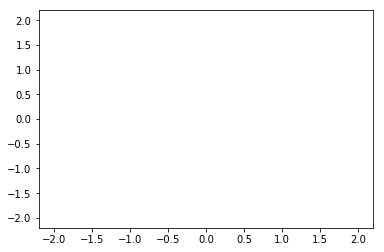

In [7]:
xinit = array([pi,0,0,0])#np.zeros(4)+0.1*np.random.normal(size = 4);
u = out.x

x = np.zeros((N, 4))
x[0] = xinit
for i in range(N-1):
    x[i+1] = x[i] + dt*acrobot_motion(x[i], u[i])
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( -2.2, 2.2))
ax.set_ylim((-2.2, 2.2))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(k):
    x1 = cos(x[k,0]+pi/2);
    y1 = sin(x[k,0]+pi/2);
    x2 = x1 + cos(x[k,0]+x[k,1]+pi/2);
    y2 = y1 + sin(x[k,0]+x[k,1]+pi/2);
    
    xs = [0, x1, x2]
    ys = [0, y1, y2]
    line.set_data(xs, ys)
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=N, interval=20, blit=True)


In [8]:
HTML(anim.to_html5_video())

In [ ]:
#brute force method, not converging

def lagrangian(input_array):
    #x is x1 to xN,followed by U0 to UN-1, followed by lambda0 to lambdaN-1
    x = np.concatenate([[pi,0,0,0],input_array[:(n-1)*4]])
    u = input_array[(n-1)*4:(n-1)*4+n]
    lam = input_array[(n-1)*4+n:-1]

    L=0
    for i in range(n-1):
        #current x
        xx = x[i*4:(i+1)*4]
        #next x
        xx_p1 = x[(i+1)*4:(i+2)*4]
        #difference between x+dt*dx and x_next
        delta = xx+dt*acrobot_motion(xx,u[i])-xx_p1
        #minimize energy
        cost = cost_function(xx,u[i])
        lagragian_term = lam[i]*(delta[0:1]%(2*pi))
        L+=cost+lagragian_term
    return L
#init = np.ones(n*4+n+n)
#out = minimize(lagrangian,init)